In [9]:
from pygrnd.optimize.qmco import *

%config InlineBackend.figure_format = "retina"

## Introduction

**Quadratic Unconstrained Binary Optimization (QUBO)** problems are a class of NP-hard combinatorial optimization problems which can be solved by quantum annealers and various classical algorithms. Although having *unconstrained* in its name, we can actually implement linear constraints into QUBOs by adding penalty matrices to the original QUBO matrix. [Grover et al. (2018)](https://arxiv.org/abs/1811.11538) gives a comprehensive introduction to this topic.

What's more, for a (single-objective) quadratic optimization problem where the variables $w_i$, $i\in\{1,\ldots,n\}$ satisfy $w_i\in[0,1]$, we can approximate each $w_i$ by its **binary representation**, so that the problem can be encoded as a QUBO. This uses the same idea as in [Palmer et al. (2021)](https://arxiv.org/abs/2106.06735), and we do not go into the details here.

This notebook provides examples for solving multicriteria quadratic optimization problems with the QUBO approach.

### Asset Allocation and Multicriteria Optimization

The asset allocation problem is one of the most famous examples of multicriteria optimization.

According to Markowitz's modern portfolio theory, for a given number of $n$ assets, each asset numbered $i\in\{1,\ldots,n\}$ can be treated as a **random variable $X_i$**, and its **expected return** $\mu_i$ and **standard deviation** $\sigma_i$ can be estimated with historical stock data.
For every two assets $i,j\in\{1,\ldots,n\}$, we can estimate their **correlation** $\rho_{i,j}\in[0,1]$, where the **covariance** of the two assets is calculated as $\sigma_{i,j} = \sigma_{i}\sigma_{j}\rho_{i,j}$, and the **covariance matrix** is defined as $\Sigma \coloneqq (\sigma_{i,j})$.
In case of $i=j$, the value $\sigma_{i,i} = \sigma_{i}^2$ is the **variance** of asset $i$.

Assume that the available amount of capital is large enough, so that the stock price of each asset does not matter, and the capital can be distributed in each asset in continuous percentages.
In this case, a **portfolio** can be encoded as a vector of weights $w = (w_1,\ldots,w_n)^\textrm{T} \in [0,1]^n$, with the sum of weights $\sum_{i=1}^n w_i = 1$.
The portfolio $w$ produces a random variable $X_w = \sum_{i=1}^n w_i X_i$, with its expected return and variance calculated as
\begin{align*}
    \mathbb{E}[X_w]
  = \mathbb{E}\bigg[\sum_{i=1}^n w_i X_i\bigg]
  = \sum_{i=1}^n w_i\, \mathbb{E}[X_i]
 &\approx \sum_{i=1}^n w_i \mu_i = \mu^\textrm{T} w \\
    \mathbb{V}[X_w]
  = \mathbb{V}\bigg[\sum_{i=1}^n w_i X_i\bigg]
  = \sum_{i=1}^n \sum_{j=1}^n w_i w_j \text{Cov}[X_i,X_j]
 &\approx \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{i,j} = w^\textrm{T} \Sigma w
\end{align*}
and its **volatility** (i.e. standard deviation) given as $\sqrt{\mathbb{V}[X_w]}$.

The goal is to find a portfolio with a maximized return and minimized volatility (note that minimizing the volatility can be achieved by minimizing the variance):

 \begin{align*}
  \max && {\mu^\textrm{T}} w \\
  \min && w^\textrm{T} \Sigma w \\
  \text{s. t.} && \textstyle\sum_{i=1}^n w_i &= 1 \\
                && w &\in [0,1]^n
\end{align*}


The linear constraint $\sum_{i=1}^n w_i = 1$ ensures that the total budget of $1=100\%$ holds;
the range constraint $w \in [0,1]^n$ says that all asset weights in the portfolio must be positive (i.e. only longs, no short sale), and each of them should not exceed $100\%$.

The two objectives and are generally conflicting.
For an optimization problem with multiple objectives, it is typically not possible to search for *the* optimal solution, but rather a solution set.
In case of portfolio optimization, this solution set is called the **efficient frontier**, the elements of which are **Pareto-optimal**.

### Multicriteria Optimization Algorithms

Consider the following general multicriteria optimization problem (where $w = (w_1,\ldots,w_n)^\textrm{T}$ is the vector of variables):

\begin{align*}
\min && f_1(w) \\[-6pt]
     && \vdots\quad \\[-3pt]
\min && f_a(w) \\
\text{s. t.} && g_1(w) &= 0 \\[-6pt]
              && \vdots\quad \\[-3pt]
              && g_b(w) &= 0 \\
              && w &\in [0,1]^n
\end{align*}

We only considering minimizing the objectives, because maximizing a function $f$ can be achieved by minimizing $-f$.

Below are some often-used methods for solving the multicriteria optimization problem above:

- **Scalarization** ("Turn Multiple Objectives into One"):

     Transform the original problem in a way, so that a desired solution can be obtained by optimizing a *single* scalar-valued objective function.

     - **Weighed Sum Method:**

          Add up the objectives with different scaling factors (the $\lambda_k$ below), then optimize that combined objective. In order to find the efficient frontier, we can solve different instances of

          \begin{align*}
          \min && \sum_{k=1}^{a} \lambda_k f_k(w) \\[-6pt]
          \text{s. t.} && g_l(w) &= 0 & \forall\,l\in\{1,\ldots,b\} \\
                    && w &\in [0,1]^n
          \end{align*}

          In case of asset allocation, if we impose the budget constraint of $100\%$ as a penalty term to the objective functions, then it is the same idea as minimizing $\mu^\textrm{T} w + \frac{\gamma}{2} w^\textrm{T}\Sigma w + \rho(1^\textrm{T} w - 1)^2$ for some $\gamma, \rho \geq 0$, a formula often seen in related papers.

     - **ε-Constraint Method:**

          This is actually the most intuitive method:
          we tell the optimizer that all but one objective function should be maintained at some value (the $c_k$ below), and then minimize that one chosen objective function $f_{k_\ast}$. Mathematically, we solve instances of (where the "$\leq$" in the second line can be changed with "$=$")

          \begin{align*}
          \min && f_{k_\ast}(w) \\
          \text{s. t.} && f_k(w) &\leq c_k & \forall\,k&\in\{1,\ldots,a\}\setminus\{k_\ast\} \\
                    && g_l(w) &= 0 & \forall\,l&\in\{1,\ldots,b\} \\
          && w &\in [0,1]^n
          \end{align*}

          In case of asset allocation, we can tell our optimizer that the portfolio's expected return should not go under a certain value, while the portfolio's volatility should be minimized. Or, in the other way around: we can also tell our optimizer that the portfolio's volatility should not exceed a certain value while maximizing the expected return.

- **Monte Carlo Method** ("Trial and Error"):

     Instead of using an optimizer algorithm, we can generate a large number of samples (solution candidates) $w \in [0,1]^n$. Then, we calculate all the $f_k(w)$ and $g_l(w)$ for each $w$, and filter out the better samples.

     In case of asset allocation, we can generate one million random portfolios, calculate their expected return and volatility, and find out the best portfolios based on the information.

## Our Package in Action

Our package aims at solving quadratic optimization problems of the kind

\begin{align*}
\min/\max && w^\textrm{T} A_{(1)} w + b_{(1)}^\textrm{T} w + c_{(1)} \\[-6pt]
          && \vdots\qquad\quad\;\;\;\vdots\qquad\;\;\vdots\;\;\; \\[-3pt]
\min/\max && w^\textrm{T} A_{(a)} w + b_{(a)}^\textrm{T} w + c_{(a)} \\
\text{s. t.} && d_{(1)}^\textrm{T} w + e_{(1)} &= 0 \\[-6pt]
              && \vdots\qquad\;\;\vdots\;\;\; \\[-3pt]
              && d_{(b)}^\textrm{T} w + e_{(b)} &= 0 \\
              && w &\in [0,1]^n
\end{align*}

where $w$ is the vector of variables, $A_{(k)}$ are real-valued matrices, $b_{(k)}$, $d_{(l)}$ are real-valued vectors, and $c_{(k)}$, $e_{(l)}$ are real constants.

### Example 1 – Asset Allocation with Randomly Generated Data

First, we randomly generate the expected returns and covariance matrix of $n=5$ assets:

In [10]:
N = 5  # Total number of assetso

np.random.seed(42)
µ = np.random.rand(N) / 5                  # Means (expected returns) of assets (random, 0-25%)
σ = pow(µ, 0.8) * (2 + np.random.rand(N))  # Standard deviations of assets (related to the means, with some perturbations)

corr = generate_correlation_matrix(N)
Σ = np.outer(σ, σ) * corr

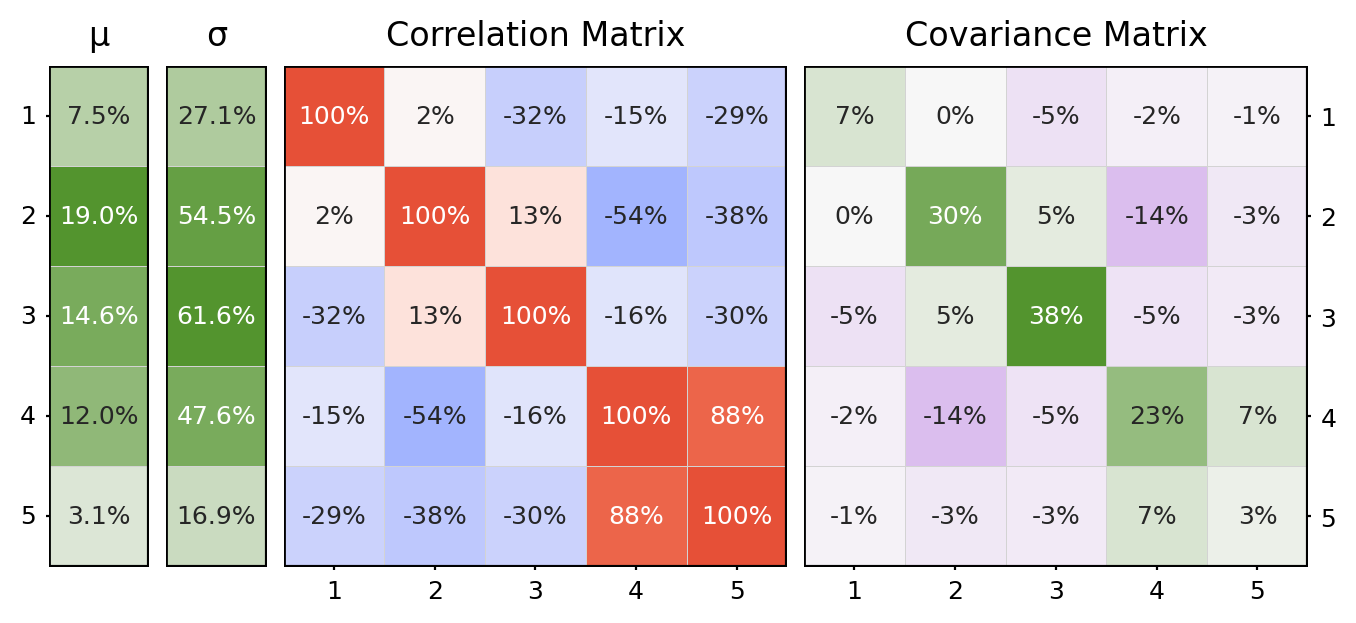

In [11]:
plot_return_volatility_matrices(µ, σ, corr, Σ)

Now, we want to solve
\begin{align*}
\max && \mu^\textrm{T} w \\
\min && w^\textrm{T} \Sigma w \\
\text{s. t.} && \textstyle\sum_{i=1}^n w_i - 1 &= 0 \\
&& w &\in [0,1]^n
\end{align*}

There are two objectives and one constraint.
Using the notations above:
- The $k$-th objective is $\min/\max w^\textrm{T}A_{(k)}w+b_{(k)}^\textrm{T}w+c_{(k)}$
- The $l$-th constraint is $d_{(l)}^\textrm{T}w+e_{(l)}=0$

We can encode the problem ("eq" in the last line stands for equality constraint):

\begin{align*}
\text{objective 1 :} &&&\text{max}, &A_{(1)} &= 0  , & b_{(1)} &= \mu, & c_{(1)} &= 0, \\
\text{objective 2 :} &&&\text{min}, &A_{(2)} &= \Sigma, & b_{(2)} &= 0  , & c_{(2)} &= 0, \\
\text{constraint 1 :} &&&\text{eq}, &d_{(1)} &= \mathrlap{(1,\ldots,1)^\textrm{T},} &&& e_{(1)} &= -1.
\end{align*}

In [12]:
objs = [('max',[0,µ,0]), ('min',[Σ,0,0])]
cstrs = [('eq',[np.ones(N),-1])]

The helper method `qubo_resolution()` returns two lists of matrices for the given objectives and constraints, with the number of binary resolution bits specified as parameter `m`. Default value is `m=6`, we use `m=4`:

In [13]:
mat_objs, mat_cstrs = qubo_resolution(objs, cstrs, m=4)

How do our rescaled matrices for the objectives and constraints look like?

`plot_matrices()` is a helper method for plotting QUBO matrices, and the usage is self-explained. Note that list indices start from `0` in Python:

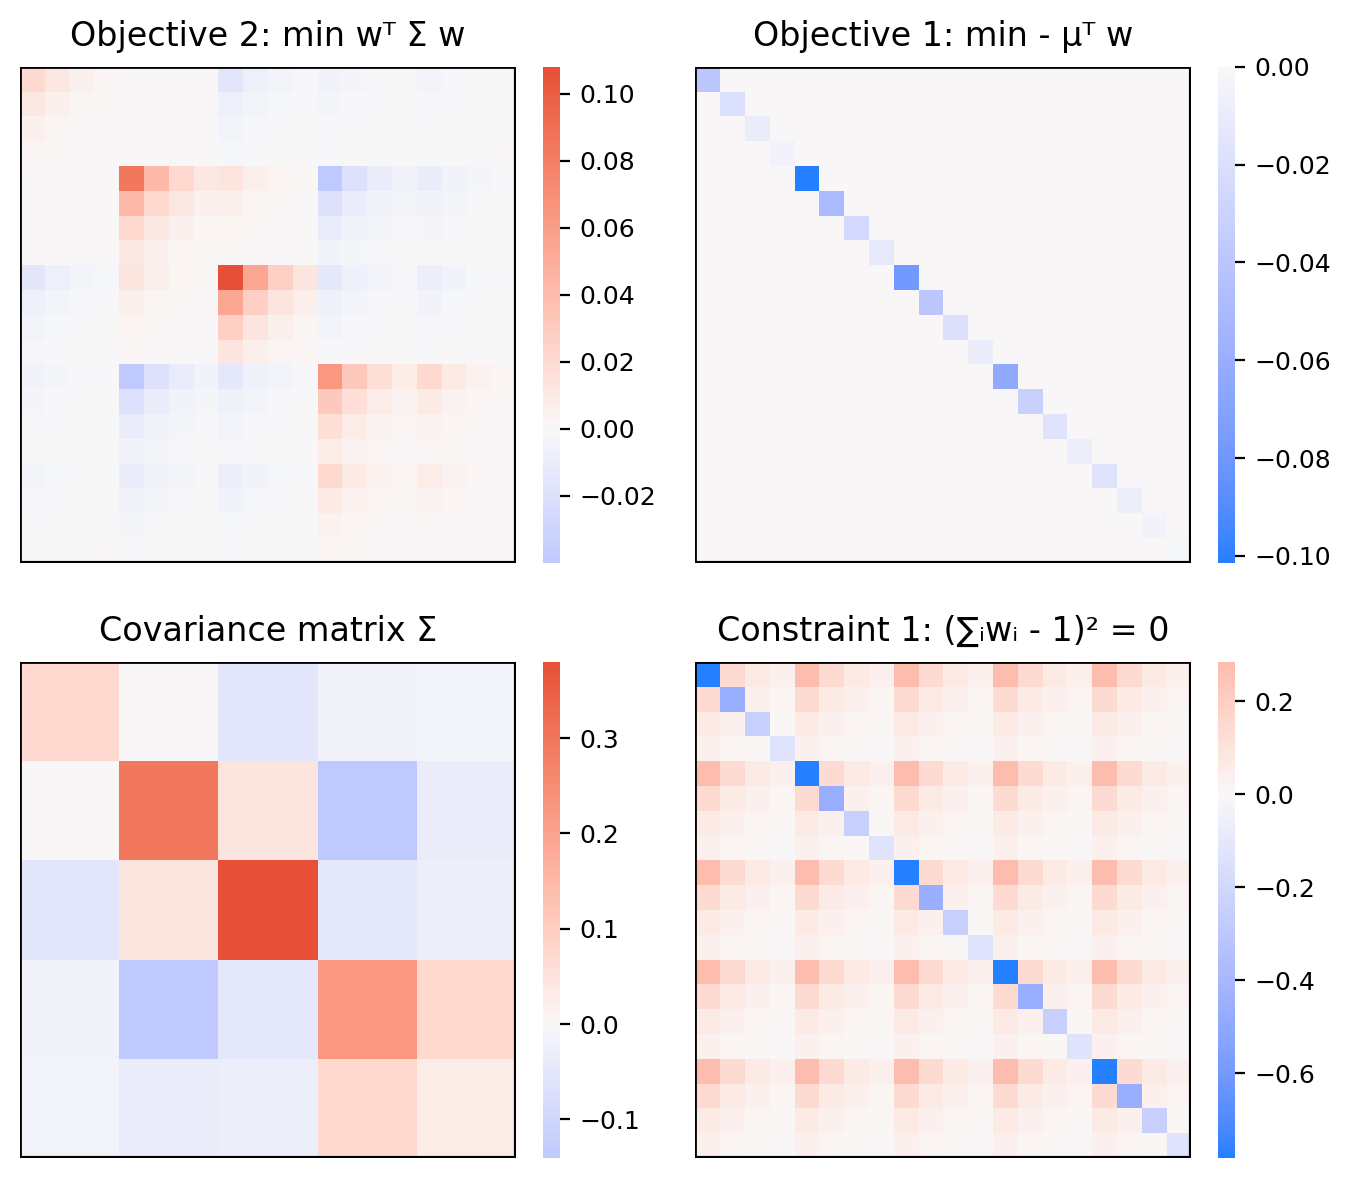

In [14]:
plot_matrices({
        (0,0): (mat_objs[1], "Objective 2: min wᵀ Σ w"),
        (0,1): (mat_objs[0], "Objective 1: min - μᵀ w"),
        (1,0): (Σ, "Covariance matrix Σ"),
        (1,1): (mat_cstrs[0], "Constraint 1: (∑ᵢwᵢ - 1)² = 0"),
    }, figsize=(7.5,6))

`solve_qubo()` solves an input problem with the weighed-sum approach.
For our problem, if we input scaling factors $\lambda_1$, $\lambda_2$ and penalty factor $P_1$, it minimizes

$$
\lambda_1\, \mu^\textrm{T} w + \lambda_2\, w^\textrm{T}\Sigma w + P_1\,(1^\textrm{T} w - 1)^2
$$

either with D-Wave System's quantum annealing hardware, or with it's simulated annealing algorithm (if no `DWtoken` is provided).

The `disp` parameter decides whether the solution details should be displayed, and the `n_tests` parameter determines the number of testing runs (default is `1`):

In [15]:
solve_qubo(objs, cstrs, λ=[0.5, 0.5], P=[20], m=4, disp=True);

[[0 1 0 1]
 [0 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 [0 0 0 0]]


,w,obj_0,obj_1,cstr_0,time
0,"[0.333, 0.0, 0.4, 0.267, 0.0]",0.115,0.057,0,5227.0


`solve_qubo_sco()` also solves with the weighed-sum approach, but it uses the classical optimization algorithm from `scipy.optimize`.

This method only needs the scaling factors $\lambda_1$, $\lambda_2$ of the objectives, and it is not needed to specify the penalty factor $P_1$ as in `solve_qubo()`. But, one can specify a starting vector `w0` of the optimization process (details on the starting vector: see our source code and `scipy`'s documentation).

In [16]:
solve_qubo_sco(objs, cstrs, λ=[0.5, 0.5], disp=True);

,w,obj_0,obj_1,cstr_0,time
0,"[0.18, 0.343, 0.123, 0.354, 0.0]",0.139,0.033,0,12931.0


The function `efficient_frontier()` is capable of computing the efficient frontier directly from our given lists of `objs` and `cstrs`. It accepts the following `method` parameters:

- Weighed Sum Scalarization:

    - `method='weighed_sum'`: *weighed sum scalarization* using **classical algorithms** from `scipy.optimize`, by using function `solve_qubo_sco()`.

    - `method='weighed_sum_annealing'`: *weighed sum scalarization* using D-Wave's packages, by using function `solve_qubo()`:

        - If a `DWtoken` is provided: use D-Wave's **quantum annealer hardware** according to the given token and `DWregion`.

        - If no `DWtoken` is provided: use D-Wave's **simulated annealing** algorithm.

- Monte Carlo:

    - `method='monte_carlo'`: make a *Monte-Carlo* simulation.

In [17]:
# Weighed Sum:
# Higher n_scale tells the function to go over a bigger amount of different weighed sums
df_ws_sp = efficient_frontier(objs, cstrs, method='weighed_sum', n_scale=50)
df_ws_sa = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', P=[500], m=3, annealingSamples=10, n_scale=50)
# Monte Carlo:
df_mc = efficient_frontier(objs, cstrs, method='mc', num=1000)   # 1000 Random Portfolios

# Because wᵀΣw is the variance, we need to take square root to get the volatility:
for df in [df_ws_sp, df_ws_sa, df_mc]:
    df['obj_1'] = np.sqrt(df['obj_1'])

100%|██████████| 1000/1000 [00:00<00:00, 7171.80it/s]


`frontiers_plotter()` visualizes our dataframes (`s_foreground` is the size of data points):

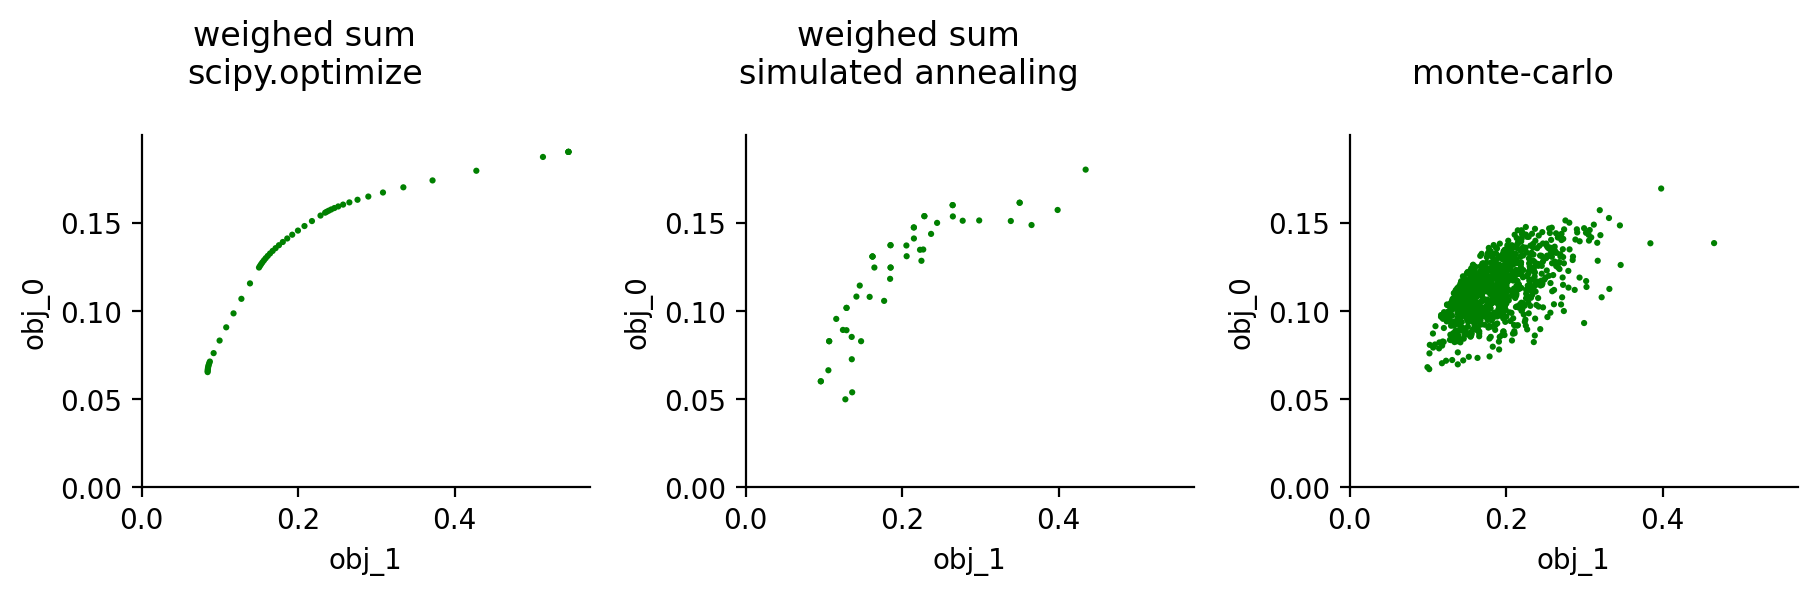

In [18]:
frontiers_plotter([df_ws_sp, df_ws_sa, df_mc],
                  ['weighed sum\nscipy.optimize', 'weighed sum\nsimulated annealing', '\nmonte-carlo'],
                  s_foreground=5)

In [29]:
token = 'DEV-****************************************'
# You can put your D-Wave token here, but the n_scale=40 below is probably too large:
# It took us 18 minutes 20 seconds to get the results (including time waiting in queue, of course)

100%|██████████| 10000/10000 [00:01<00:00, 5010.68it/s]


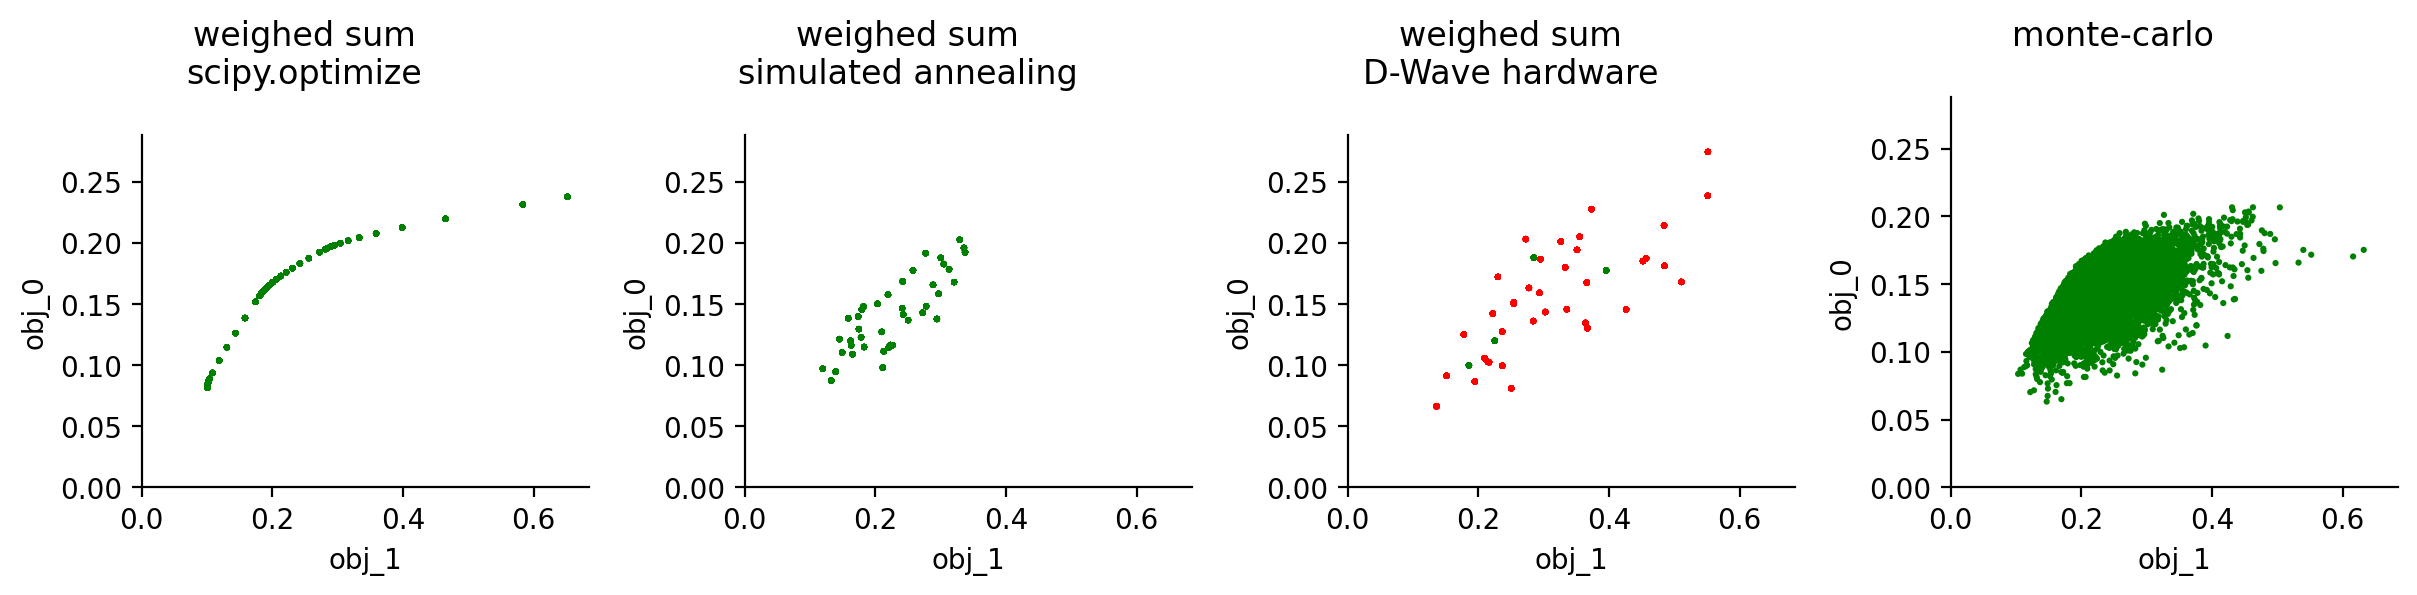

In [19]:
df_ws_sp_ = efficient_frontier(objs, cstrs, method='weighed_sum', n_scale=40)
df_ws_sa_ = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', P=[200], n_scale=40, m=4)
df_ws_dw_ = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', P=[1000], n_scale=40, m=4, DWtoken=token)
df_mc_ = efficient_frontier(objs, cstrs, method='mc', include_worse_samples=True)
for df in [df_ws_sp_, df_ws_sa_, df_ws_dw_, df_mc_]:
    df['obj_1'] = np.sqrt(df['obj_1'])
frontiers_plotter([df_ws_sp_, df_ws_sa_, df_ws_dw_, df_mc_],
                  ['weighed sum\nscipy.optimize', 'weighed sum\nsimulated annealing', 'weighed sum\nD-Wave hardware', 'monte-carlo'],
                  s_foreground=5)

#### ε-constraint method

We can also do the ε-constraint scalarization:
for a range of different $\text{ret}$ (possible portfolio expected returns), we solve
\begin{align*}
\min && w^\textrm{T} \Sigma w \\
\text{s. t.} && \textstyle\sum_{i=1}^n w_i - 1 &= 0 \\
              && \mu^\textrm{T} w - \text{ret} &= 0 \\
&& w &\in [0,1]^n
\end{align*}

This optimization problem has one objective and two constraints.

Using our methods, only the portfolio's expected return (linear) can be put under constraint, but not its variance (quadratic).

The first constraint must not be violated (solutions with `cstrs[0]` violated will be marked red). But, as our goal is to find the whole the efficient frontier, the second constraint on the expected return is only a soft constraint.

*Work in progress: To be implemented into `efficient_frontier()`*

In [19]:
objs = [('min',[Σ,0,0])]

# For different values of ret, we need to input different constraints:
df_eps_sp = pd.concat(solve_qubo_sco(objs, cstrs=[('eq',[np.ones(N),-1]), ('eq',[µ,-ret])], λ=[1], n_tests=10, disp=False)
                      for ret in tqdm(np.arange(0.01,0.2,0.01)))    # scipy.optimize
df_eps_sa = pd.concat(solve_qubo(objs, cstrs=[('eq',[np.ones(N),-1]), ('eq',[µ,-ret])], λ=[1], P=[20,10], m=6, n_tests=10, disp=False)
                      for ret in tqdm(np.arange(0.01,0.2,0.01)))    # simulated annealing

for df in [df_eps_sp, df_eps_sa]:
    # Because volatility is called 'obj_1' in the previous dataframes, we take the square root of 'obj_0' and call it 'obj_1', too:
    df['obj_1'] = np.sqrt(df['obj_0'])
    # We also want the expected returns of portfolios as 'obj_0':
    df['obj_0'] = [np.dot(µ, w) for w in df['w']]

100%|██████████| 19/19 [00:00<00:00, 33.30it/s]


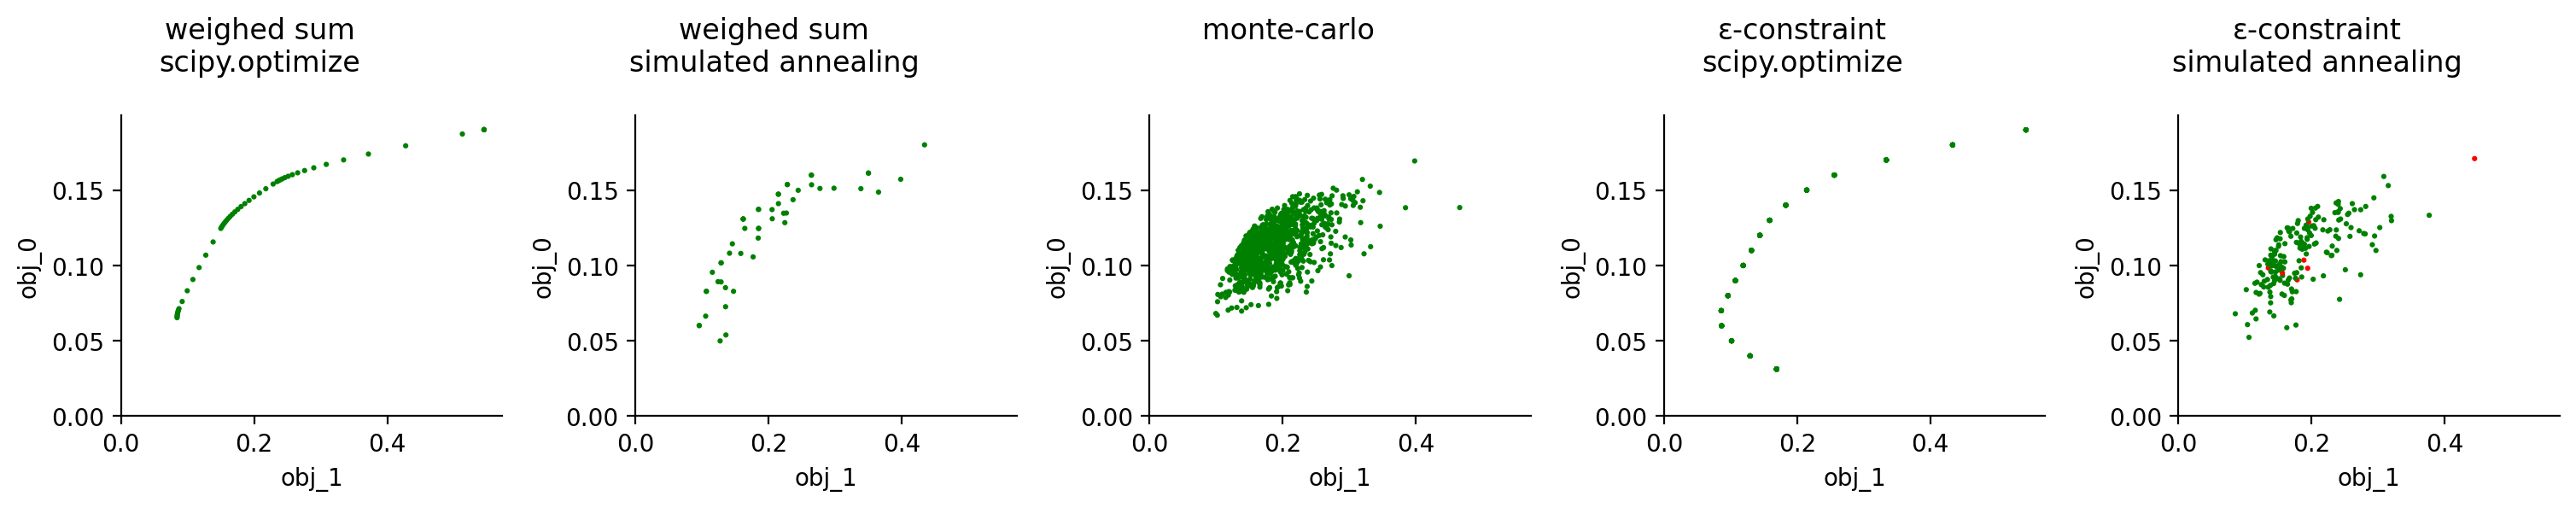

In [20]:
frontiers_plotter([df_ws_sp, df_ws_sa, df_mc, df_eps_sp, df_eps_sa],
                  ['weighed sum\nscipy.optimize', 'weighed sum\nsimulated annealing', 'monte-carlo\n', 'ε-constraint\nscipy.optimize', 'ε-constraint\nsimulated annealing'],
                  s_foreground=5)

### Example 2 – Asset Allocation with Real Data and a Third Objective

This time, we have another matrix $C$ which behaves similar to the covariance matrix, and we want to additionally minimize $\sqrt{w^\textrm{T} C w}$.

In [21]:
μ = np.array([5.3, 6.0, 6.5, 5.6, 6.0, 8.0, 8.5, 0.3, 1.0, 3.2, 0.4, 0.3, 0.0]) / 100
σ = np.array([13.0, 14.0, 11.2, 14.1, 12.7, 13.0, 18.0, 4.0, 3.6, 5.6961, 2.5, 2.1, 0.0]) / 100

N = len(μ)  # Number of Asset Classes
corr = np.array([
    [100,  90,  48,  44,  51,  41,  50,  48,  59,  40,  53,  41,   0],
    [ 90, 100,  59,  65,  67,  50,  57,  41,  57,  30,  50,  33,   0],
    [ 48,  59, 100,  80,  77,  65,  95,  11,  36,  35,  30,  14,   0],
    [ 44,  65,  80, 100,  81,  56,  71,   6,  31,  15,  26,   5,   0],
    [ 51,  67,  77,  81, 100,  48,  71,  -1,  16,  10,  14,   1,   0],
    [ 41,  50,  65,  56,  48, 100,  61,   9,  37,   9,  10,   6,   0],
    [ 50,  57,  95,  71,  71,  61, 100,   9,  33,   9,  35,  11,   0],
    [ 48,  41,  11,   6,  -1,   9,   9, 100,  79,  44,  79,  88,   0],
    [ 59,  57,  36,  31,  16,  37,  33,  79, 100,  39,  91,  81,   0],
    [ 40,  30,  35,  15,  10,   9,   9,  44,  39, 100,  16,  30,   0],
    [ 53,  50,  30,  26,  14,  10,  35,  79,  91,  16, 100,  84,   0],
    [ 41,  33,  14,   5,   1,   6,  11,  88,  81,  30,  84, 100,   0],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100],
]) / 100
Σ = np.outer(σ, σ) * corr   # "*" is pointwise multiplication

# The code below is for calculating the new matrix C
S = (np.array([
    [ 0.0000,  0.0000,  0.0000,  0.0022, 24.9988,  0.0000,  0.0000],
    [ 0.6161, -0.5557,  0.0000, 30.3143, 11.2345,  0.5268, 10.0215],
    [ 1.6421, -1.1289, 19.2911,  6.8378,  0.0000,  2.9091, 20.8736],
    [ 0.0000,  0.0000, 34.9767,  3.8058,  0.0000,  0.0000,  3.8686],
    [ 0.0000,  0.0000, 35.1398,  2.7636,  0.0000,  0.0000, 13.3643],
    [ 0.0000,  0.0000,  0.0000, 51.8763,  0.0000,  0.0000,  0.0000],
    [ 0.0000,  0.0000,  0.0000, 46.5500,  0.0000,  0.0000, 15.8750],
    [10.4283, -1.9776,  0.0000,  1.5036,  0.0000,  0.2047,  0.0492],
    [ 8.0115, -2.5329,  0.0000,  0.0000,  0.0000, 11.5410,  3.9497],
    [ 0.0000,  0.0000,  0.0000, 46.5500,  0.0000,  0.0000, 25.0000],
    [ 8.7100, -2.0042,  0.0000,  0.0087,  0.0000,  9.9467,  0.8661],
    [10.3815, -2.7811,  0.0000,  0.0000,  0.0000,  6.6325,  0.0201],
    [ 1.2287, -0.0604,  0.0000,  0.0000,  0.0000,  2.0947,-40.9288]
]) / 100).T
def C(α):
    return np.array([
        [  1,   α,   α,   α, 1/4],
        [  α,   1, 3/4, 3/4, 1/4],
        [  α, 3/4,   1, 1/2, 1/4],
        [  α, 3/4, 1/2,   1, 1/4],
        [1/4, 1/4, 1/4, 1/4,   1]
    ])
S = S[[0,2,4,5,6],:]
C = S.T @ C(0) @ S

That is to say, we want to solve the following problem:
\begin{align*}
\max && \mu^\textrm{T} w \\
\min && w^\textrm{T} \Sigma w \\
\min && w^\textrm{T} C w \\
\text{s. t.} && \textstyle\sum_{i=1}^{n} w_i - 1 &= 0 \\
&& w &\in [0,1]^{n}
\end{align*}

In [22]:
objs = [('max',[0,µ,0]), ('min',[Σ,0,0]), ('min',[C,0,0])]
cstrs = [('eq',[np.ones(N),-1])]

The following function is for randomly generating more representative asset weights ("$w$") for Monte Carlo:

Each element $w_i$ of the vector $w$ is assigned to a value in $[0,1]$ as follows:

- For $60\%$ of the time, $w_i$ equals 0;
- For $20\%$ of the time, $w_i$ is calculated as $\max\{X_1,\ldots,X_5\}$, where $X_i\sim \textit{Uniform}(0,1)$ are independent;
- For $20\%$ of the time, $w_i$ is calculated as $\min\{X_1,\ldots,X_5\}$, where $X_i\sim \textit{Uniform}(0,1)$ are independent.

Then the vector $w$ is normalized, to make sure that it's 1-norm becomes 1.

In [23]:
def rand_vec(N):
    def func(vect):
        r = np.random.randint(0,9)
        if r <= 1:
            return np.max(vect)
        elif r <= 7:
            return 1e-10  # Not exactly 0, to avoid errors from division by 0
        else:
            return np.min(vect)
    arr = np.random.uniform(size=(5,N))
    res = np.apply_along_axis(func, 0, arr)
    w = res / np.sum(res)
    return w

100%|██████████| 10000/10000 [00:03<00:00, 2868.69it/s]


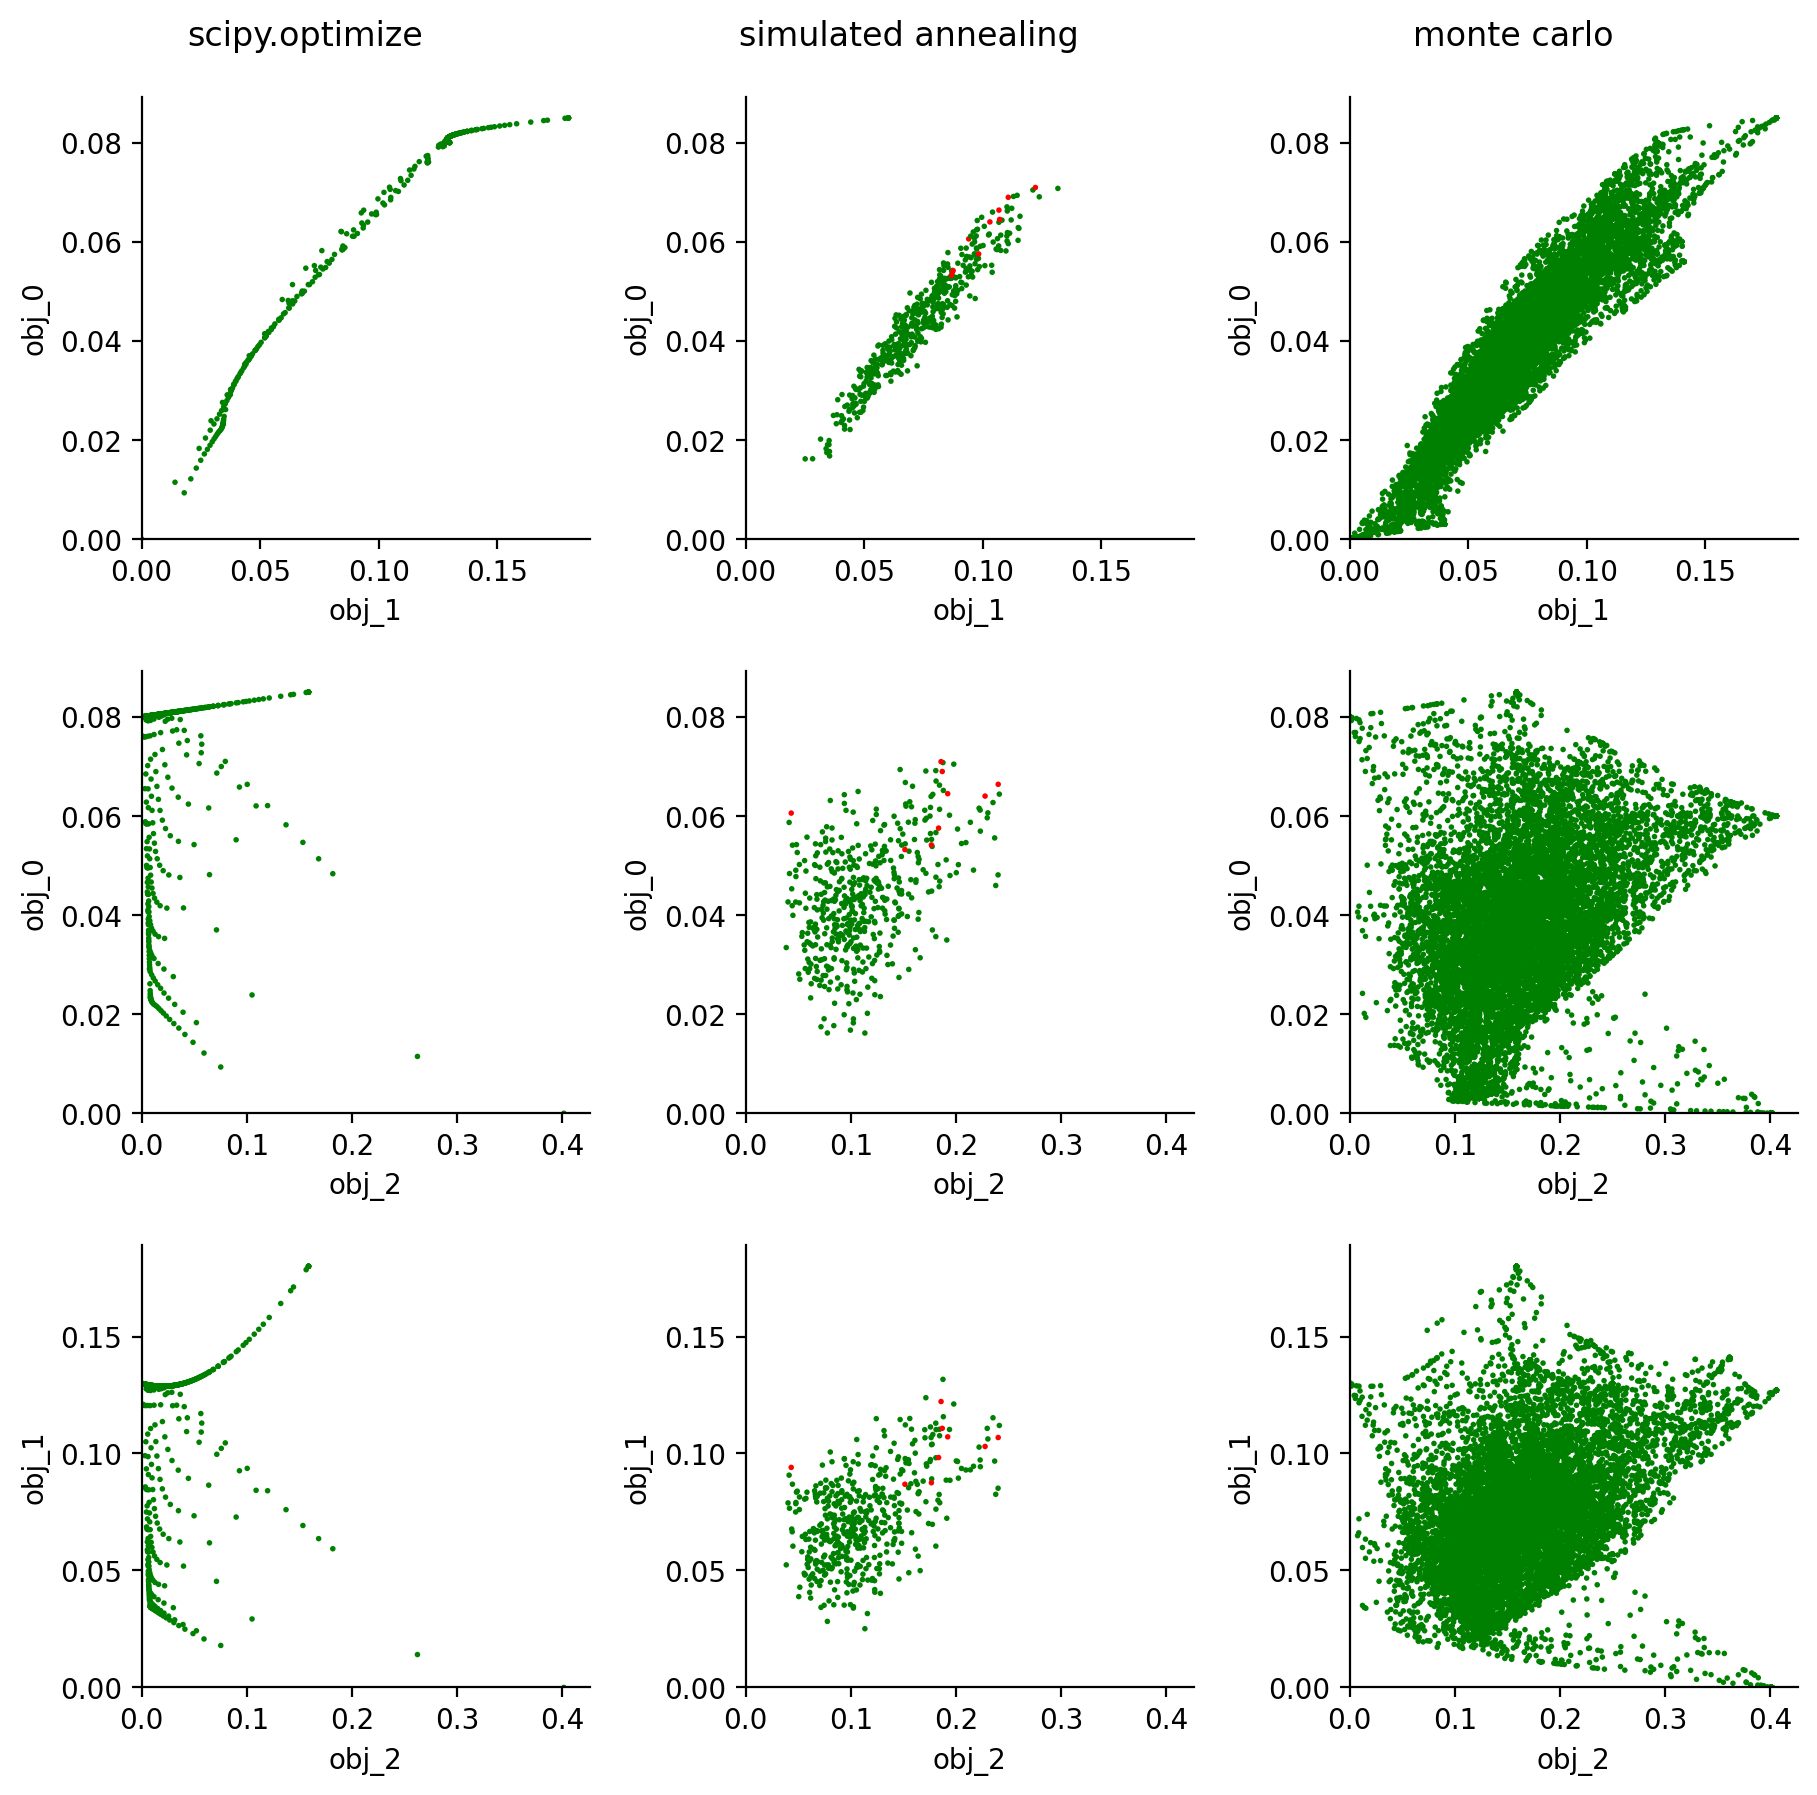

In [24]:
df1 = efficient_frontier(objs, cstrs, method='weighed_sum', n_scale=30)
df2 = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', n_scale=30, P=[100])

# Pass the rand_vec function as the random portfolio generator for the Monte Carlo method
df3 = efficient_frontier(objs, cstrs, method='monte_carlo', rand_vec=rand_vec)

# Take the square root of variance and the new objective
for df in [df1, df2, df3]:
    df['obj_1'] = np.sqrt(df['obj_1'])
    df['obj_2'] = np.sqrt(df['obj_2'])

frontiers_plotter([df1, df2, df3], ['scipy.optimize', 'simulated annealing', 'monte carlo'], s_foreground=4)

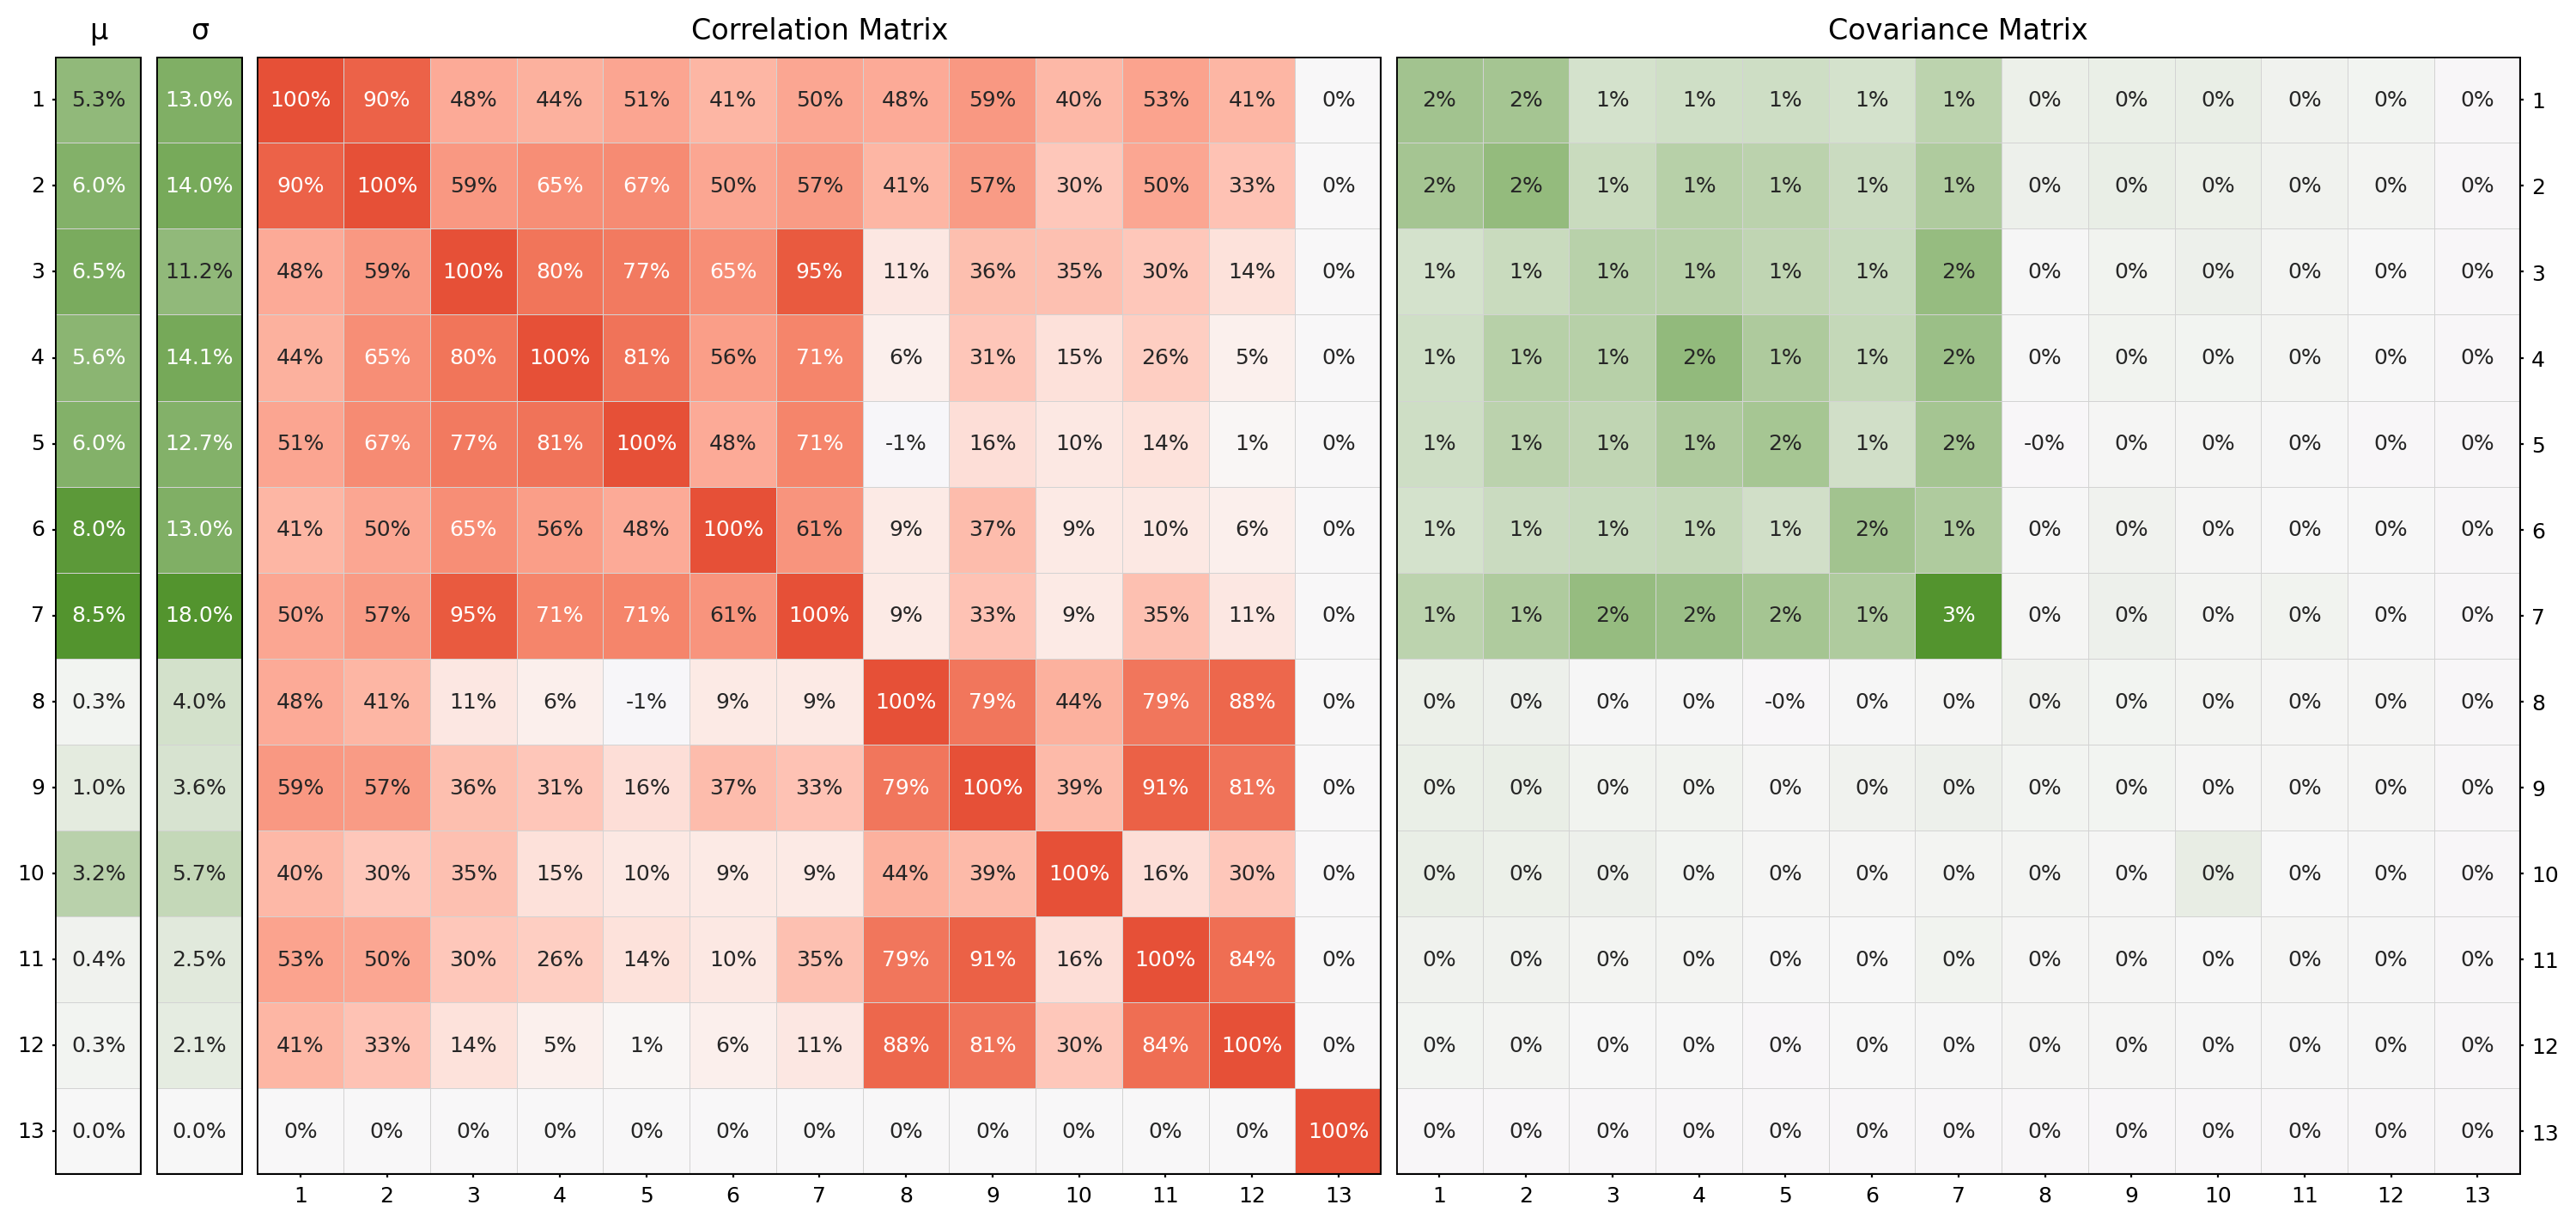

In [25]:
plot_return_volatility_matrices(µ, σ, corr, Σ)

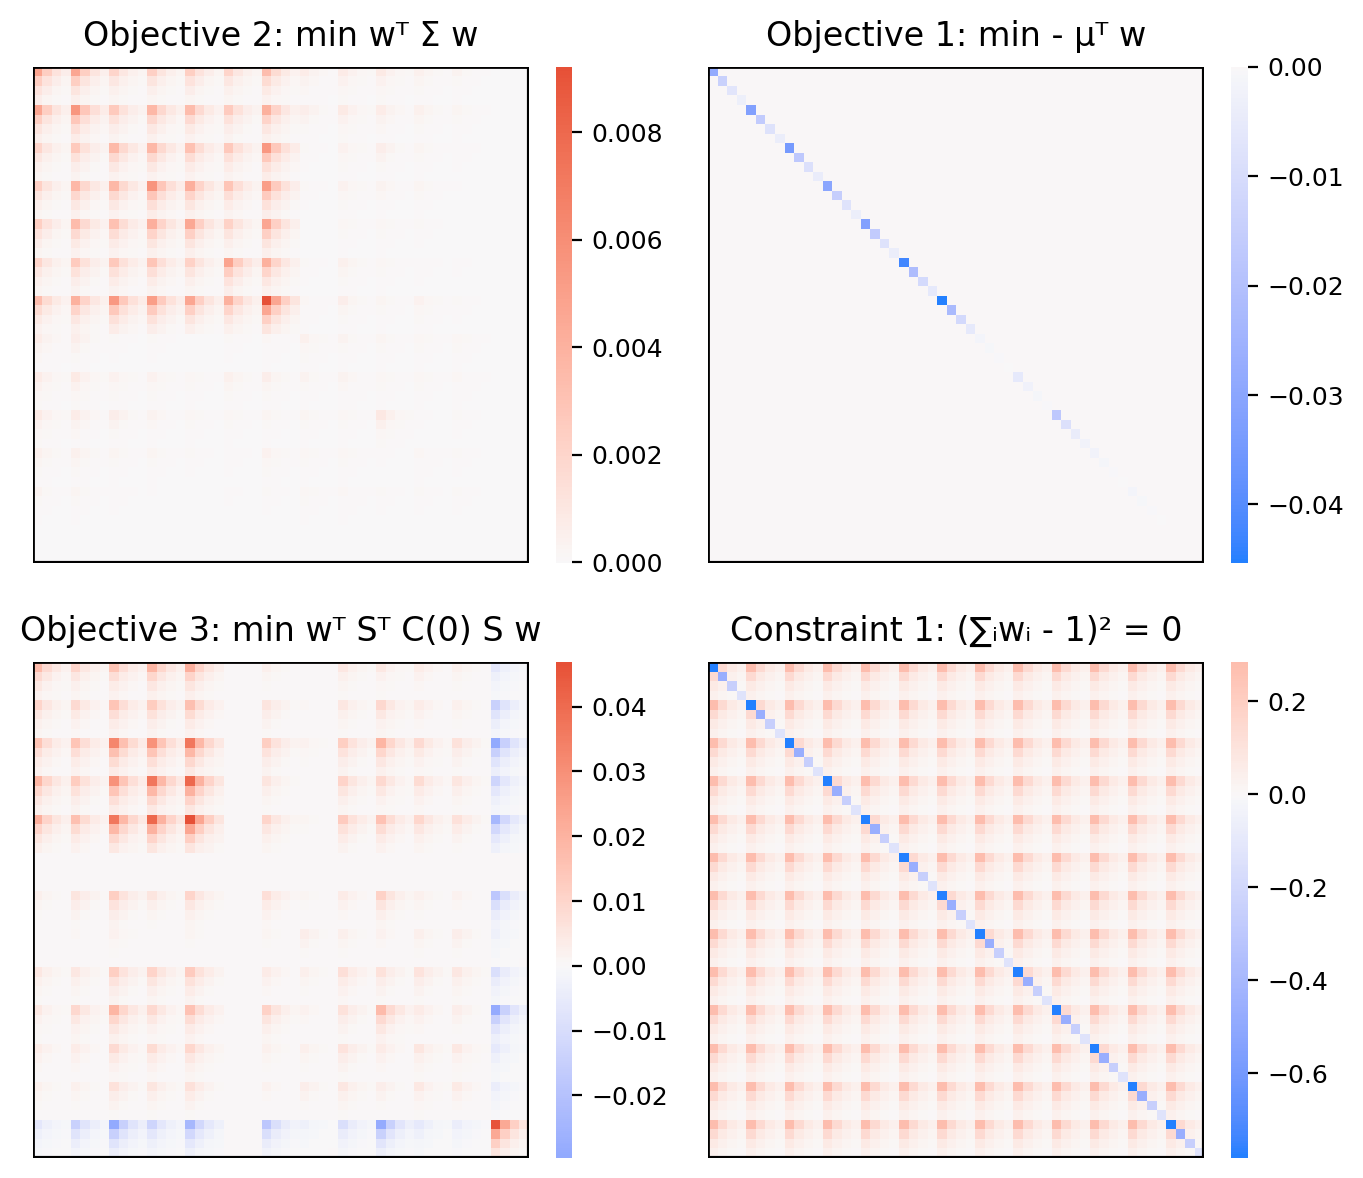

In [26]:
mat_objs, mat_cstrs = qubo_resolution(objs, cstrs, m=4)
plot_matrices({
        (0,0): (mat_objs[1], "Objective 2: min wᵀ Σ w"),
        (0,1): (mat_objs[0], "Objective 1: min - μᵀ w"),
        (1,0): (mat_objs[2], "Objective 3: min wᵀ Sᵀ C(0) S w"),
        (1,1): (mat_cstrs[0], "Constraint 1: (∑ᵢwᵢ - 1)² = 0"),
    }, figsize=(7.5,6))

In [27]:
df = solve_qubo(objs, cstrs, λ=[0.5, 0.5, 0.5], P=[20], m=6, disp=True)

[[0 0 1 1 0 0]
 [0 0 1 1 1 1]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]
 [0 0 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 0]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 1]
 [0 0 1 0 0 1]]


,w,obj_0,obj_1,obj_2,cstr_0,time
0,"[0.19, 0.238, 0.032, 0.048, 0.048, 0.079, 0.0,...",0.04,0.006,0.014,0,11183.0


### Example 3 – Other Simple Problems

Consider the following problem: we want to find different $x_1,x_2 \in[0,1]$ such that $x_1+x_2=1$.

This is the same as solving the following multicriteria optimization problem (with no objectives):

\begin{align*}
\text{s. t.} && \big(\begin{smallmatrix}1\\1\end{smallmatrix}\big)^{\!\textrm{T}}x - 1 & =0 \\
&& x & \in[0,1]^2
\end{align*}

So, we have zero objectives, and one constraint: $d^\textrm{T}x+e=0$, where $d=\!\big(\begin{smallmatrix}1\\1\end{smallmatrix}\big)$, in Python: `np.ones(2)`, and $e=-1$.

In [28]:
objs = []
cstrs = [('eq',[np.ones(2),-1])]
mat_objs, mat_cstrs = qubo_resolution(objs, cstrs, m=6)

There are zero objectives and one constraint, so the returned `mat_objs` is an empty list, while `mat_cstrs` is a list of length 1.

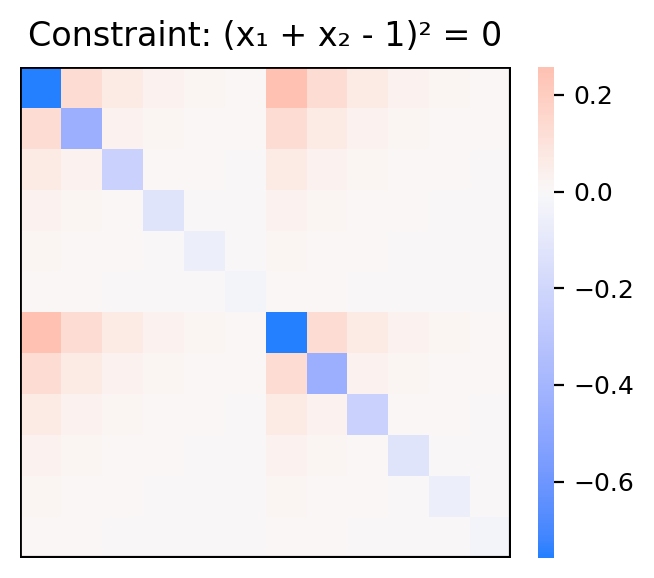

In [29]:
plot_matrices({
        (0,0): (mat_cstrs[0], "Constraint: (x₁ + x₂ - 1)² = 0"),
    }, figsize=(4,3))

100%|██████████| 1000/1000 [00:00<00:00, 16779.36it/s]


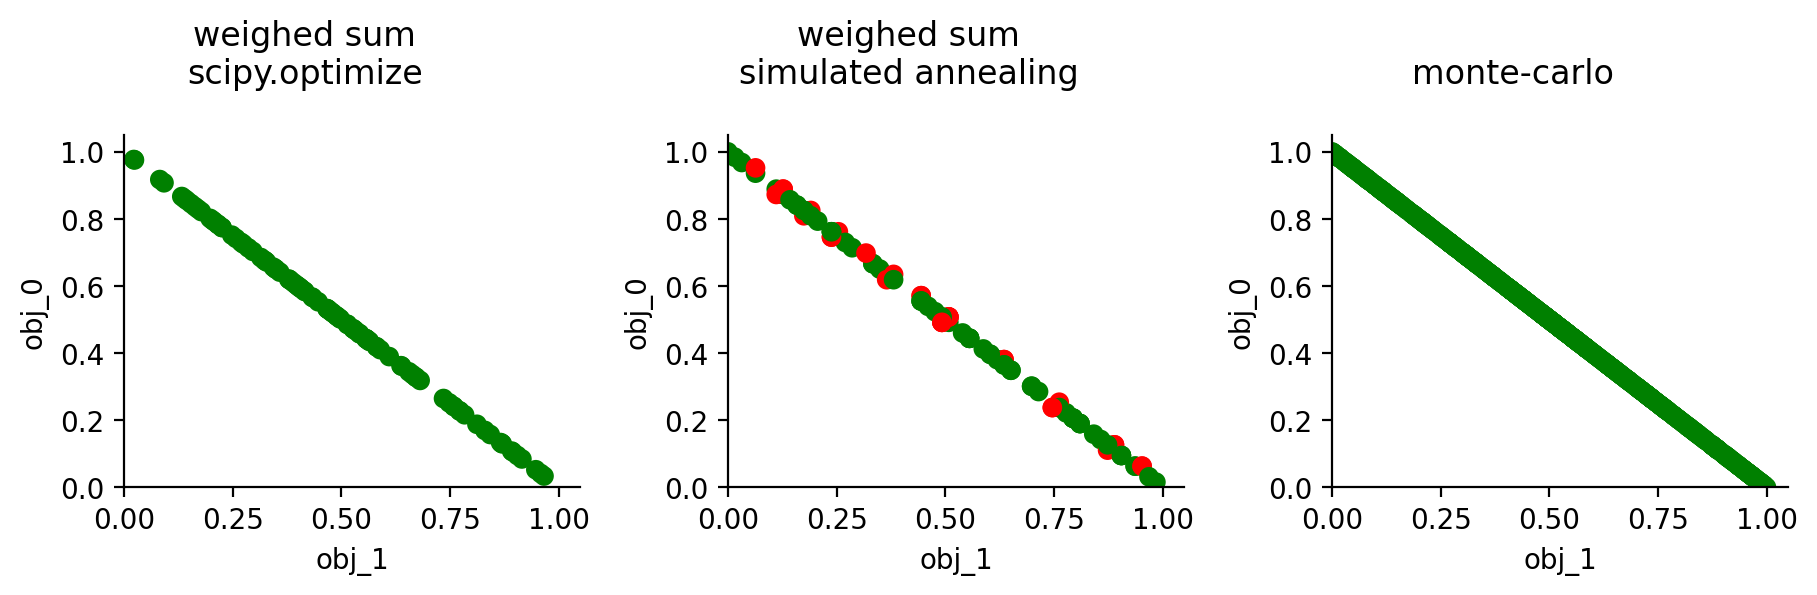

In [30]:
# For this problem, we have no objectives. Therefore, only λ=[] is possible, no matter how you want to scale it.
# n_tests=100 tells the function to do 100 same tests on each of the different λ. Default is n_tests=1.
df__1 = efficient_frontier(objs, cstrs, method='weighed_sum', n_tests=100)
df__2 = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', P=[1], n_tests=100)

df__3 = efficient_frontier(objs, cstrs, method='monte_carlo', num=1000)

# frontiers_plotter() only accepts dataframes with objective function values named 'obj_0', 'obj_1', etc.
# So we have to create the respective columns.
for df in [df__1, df__2, df__3]:
    df['obj_0'] = [w[0] for w in df['w']]
    df['obj_1'] = [w[1] for w in df['w']]

frontiers_plotter([df__1, df__2, df__3], ['weighed sum\nscipy.optimize', 'weighed sum\nsimulated annealing', '\nmonte-carlo'], s_foreground=50)

Red points are solutions which violate the constraint.
We can increase the number of annealing Samples (parameter: `annealingSamples`, default is `1`) for simulated annealing:

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


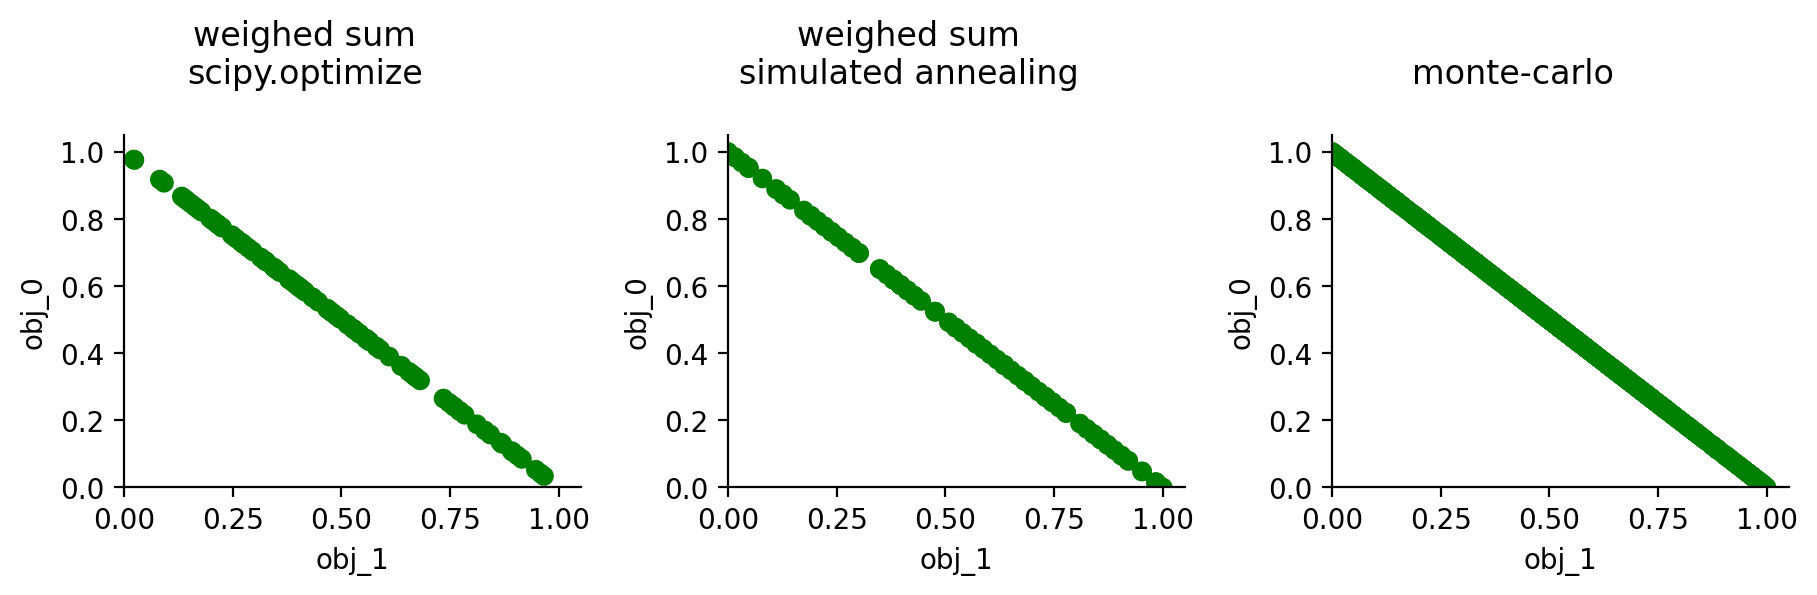

In [31]:
df__2 = efficient_frontier(objs, cstrs, method='weighed_sum_annealing', P=[1], n_scale=50, n_tests=100, annealingSamples=100)
df__2['obj_0'] = [w[0] for w in df__2['w']]
df__2['obj_1'] = [w[1] for w in df__2['w']]
frontiers_plotter([df__1, df__2, df__3], ['weighed sum\nscipy.optimize', 'weighed sum\nsimulated annealing', '\nmonte-carlo'], s_foreground=50)